# Active Contours

## Active Contours using Parametric Curves

In [1]:
from __future__ import division

#os.chdir(os.getcwd+"/home/margot/Documents/Machine_Learning/Active_Contours")
from nt_toolbox.general import *
from nt_toolbox.signal import *
from numpy import *
import matplotlib.pyplot as plt
from cmath import *
#from home.margot.Documents.Machine_Learning.Active_Contours.nt_toolbox.nt_toolbox.general.py import *
#from nt_toolbox.signal import *
#pylab inline
#matplotlib inline
#load_ext autoreload
#autoreload 2

#### Polygone initial

L'idée est d'associer les contours à des courbes paramétriques. Chaque courbe est discrétisée en p segments et est représentée par un vecteur complexe.

In [2]:
gamma0 = np.array([.78, .14, .42, .18, .32, .16, .75, .83, .57, .68, .46, .40, .72, .79, .91, .90]) + 1j*np.array([.87, .82, .75, .63, .34, .17, .08, .46, .50, .25, .27, .57, .73, .57, .75, .79])

#### Visualisation de la courbe initiale

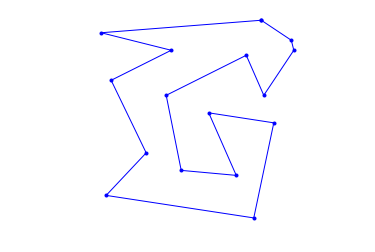

In [3]:
periodize = lambda gamma: concatenate((gamma, [gamma[0]]))
def cplot(gamma,s='b',lw=1): 
    plt.plot(real(periodize(gamma)), imag(periodize(gamma)), s, linewidth=lw)
    plt.axis('equal')
    plt.axis('off')
    
cplot(gamma0,'b.-');

Nombre de points de la courbe discrète (= nombre de segments)

In [4]:
p = 256

En fonction de la longueur d'un arc (ie: un segment), nous allons échantillonner différemment la courbe. Les lignes de code ci dessous permettent de définir des fonctions utilisées ensuite pour obtenir une courbe "lisse".


In [5]:
# interpc: fonction prenant trois arguments et donnant un complexe. La fonction interp de python interpole les vecteurs de
# données xf et real(yf) (ou imag(yf)) et évalue les valeurs obtenues en x.
interpc = lambda x,xf,yf: interp(x,xf,real(yf)) + 1j * interp(x,xf,imag(yf))
#curvabs: fonction prenant en entrée gamma (vecteur), puis retourne un vecteur commençant par 0 et la somme cumulée 
# de la différence entre gamma sans le premier terme et gamma sans le dernier terme
curvabs = lambda gamma: concatenate( ([0], cumsum( 1e-5 + abs(gamma[:-1:]-gamma[1::]) ) ) )

#arange(0,p) = vecteur de 0 à p-1 --> est bien composé de p points.
#resample1 calcule l'interpolation entre un vecteur de 0 à p-1 pris en entrée et normalisé et le vecteur d  divisé par
# d[-1] et gamma
resample1 = lambda gamma,d: interpc(arange(0,p)/float(p),  d/d[-1],gamma)
#periodize: fonction créée plus haut. Concatène le vecteur d'entrée avec sa première composante
resample = lambda gamma: resample1( periodize(gamma), curvabs(periodize(gamma)) )

#### Courbe initiale gamma 1

In [6]:
gamma1 = resample(gamma0)

#### Visualisation de la courbe initiale gamma 1

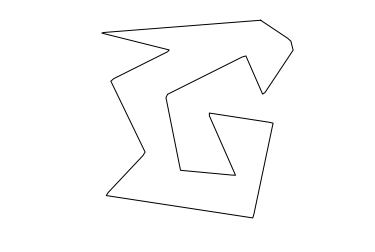

In [7]:
cplot(gamma1, 'k')

#### Différence finies
Décentrage en amont (forward differences: FwdDiff) et en aval (backward differences: BwdDiff).

In [8]:
shiftR = lambda c: concatenate( ([c[-1]],c[:-1:]) ) #mettre dernier élément devant 
shiftL = lambda c: concatenate( (c[1::],[c[0]]) ) #mettre premier élément derrière
BwdDiff = lambda c: c - shiftR(c)
FwdDiff = lambda c: shiftL(c) - c

#### Calcul de la tangente et de la normale à une courbe

In [9]:
normalize = lambda v: v/maximum(abs(v),1e-10)
tangent = lambda gamma: normalize( FwdDiff(gamma) )
normal = lambda gamma: -1j*tangent(gamma)

#### Déplacement de la courbe dans la direction de sa normale

In [10]:
delta = .03
gamma2 = gamma1 + delta * normal(gamma1) #dans la direction de la normale
gamma3 = gamma1 - delta * normal(gamma1) #dans la direction opposée à la normale

#### Visualisation

(0.09818192340611909,
 0.979037189504653,
 0.011000256259768859,
 0.942237845572892)

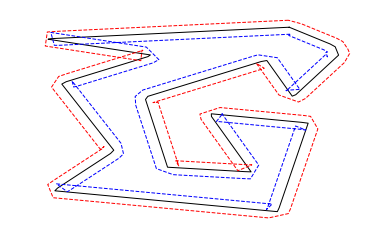

In [11]:
cplot(gamma1, 'k') #noir: courbe initiale lissée (après interpolation)
cplot(gamma2, 'r--') #rouge: direction de la normale --> courbe plus à l'extérieur
cplot(gamma3, 'b--') #bleu: direction opposée à la normale --> courbe à l'intérieur de la courbe initiale
plt.axis('tight') 
plt.axis('off')

 ### Evolution by mean curvature

On appelle évolution d'une courbe une série de courbes $\gamma_s$ indexées par un paramètre d'évolution $s$.
Afin d'évaluer la courbe intiale, dans notre cas: $\gamma_0$, il suffit de minimiser son énergie $E(\gamma)$ par une méthode de descente de gradient.

La manière la plus simple d'obtenir l'évolution d'une courbe est la méthode de "mean curvature", que l'on peut traduire méthode de "courbure moyenne". Cela correspond à trouver la minimisation de la longueur de la courbe:
$$E(\gamma) = \int_0^1 ||\gamma ' (t)|| dt $$



In [12]:
normalC = lambda gamma: BwdDiff(tangent(gamma)) / abs( FwdDiff(gamma) )

Intervalle de temps avant une évolution, nombre maximal d'itérations, initialisation de de la courbe $\gamma_0$

In [13]:
dt = 0.001 / 100

In [14]:
Tmax = 3.0 / 100
niter = round(Tmax/dt) #3000

In [15]:
gamma = gamma1

Evolution de la courbe $\gamma$

In [16]:
gamma = gamma + dt * normalC(gamma)

Un échantillonnage de la courbe est appliqué afin de paramétrer la vitesse d'évolution (la stabiliser).

In [17]:
gamma = resample(gamma)

#### Exercice 1:  Perform the curve evolution. You need to resample it a few times.

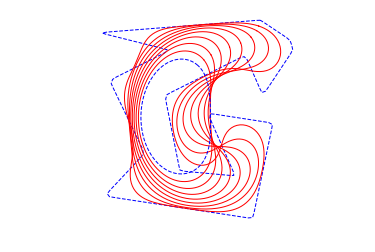

In [18]:
aff = np.around(linspace(1,niter,10)) #liste utilisée pour l'affichage. On veut avoir 10 courbes, d'où on initialise
#un vecteur de 10 valeurs espacées équitablement entre 1 et niter=3000.
#print(displist)
#cplot(gamma, 'k')
k = 0 #initialisation de la variable parcourant aff

for i in range (1,niter+1): #1 à 3000
    gamma = resample(gamma + dt*normalC(gamma)) # échantillonage à chaque itération
    if i==aff[k] :
        if (i==1 or i==niter) :  #courbe la plus au centre ou plus à l'extérieur, ie: 1ère valeur de aff ou dernière
            cplot(gamma, 'b--') #alors on dessine en pointillés noirs
        else:
            cplot(gamma, 'r')
             #sinon on dessine en trait plein rouge          
        
        k = k+1

### Geodesic Active Contours

Le principe est le même que précédemment sauf que nous allons utiliser la longueur pondérée de la curvature. C'est pourquoi nous pouvons écrire la nouvelle énergie à minimiser:
$$E(\gamma) = \int_0^1 W(y(t))||\gamma ' (t)|| dt $$

$W > 0$ est une métrique géodésique, c'est à dire que ce sont les poids correspondant aux chemins les plus courts, si ils existent, entre deux points.
Là où l'image doit être segmentée, $W(x)$ sera petit.

In [19]:
n = 200 #taille de l'image

On créé un vecteur de poids et on les visualise.

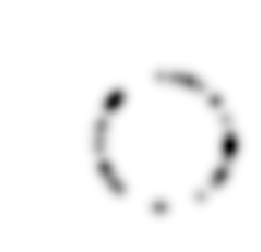

In [20]:
nbumps = 40
theta = random.rand(nbumps,1)*2*pi
r = .6*n/2
a = np.array([.6*n,.6*n])

A0 = int(a[0]) + r*np.cos(theta)
A1 =int(a[1]) + r*np.sin(theta) 
x = around(A0)
y = around(A1)
W = zeros([n,n])
for i in arange(0,nbumps):
    W[int(x[i]),int(y[i])] = 1
    
W = gaussian_blur(W,6.0)
W = rescale( -minimum(W,.05), .3,1)

#Visualisation
imageplot(W)

On cherche désormais à visualiser la norme du gradient des poids: $||\nabla W||$.

La norme du gradient est très utilisée afin de déterminer des contours dans des images. En effet, le contour est situé au niveau des maximas locaux repérés dans la direction du gradient. A REOVIR SI ON MET --> je pense pas enfait

In [21]:
G = grad(W) #calcul du gradient
G = G[:,:,0] + 1j*G[:,:,1] #Laura ici tu vas pouvoir nous aider ;)    Je sais plus ce que ça fait l'ajout du dernier indice

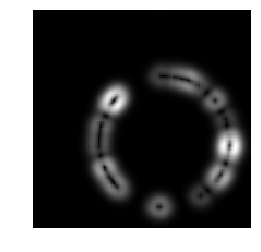

In [22]:
imageplot(abs(G))

L'image ci-dessus paraît complémentaire à l'image précédemment visualisée. Les parties avec plus ou moins d'intensité coïncident dans les deux images.

Définitions de fonctions pour évaluer le gradient et le potentiel le long d'une coure.b

In [23]:
EvalG = lambda gamma: bilinear_interpolate(G, imag(gamma), real(gamma))
EvalW = lambda gamma: bilinear_interpolate(W, imag(gamma), real(gamma))

In [24]:
r = .98*n/2 #rayon
p = 128 #nombre de points sur la courbe
theta = transpose( linspace(0, 2*pi, p+1) )#transposée d'un vecteur de longueur p+1 allant de 0 à 2pi (intervalles égaux)
theta = theta[0:-1] #sans la derniere valeur, car cos(0)=cos(2pi) et idem pour sin ??
gamma0 = n/2 * (1 + 1j) +  r*(np.cos(theta) + 1j*np.sin(theta)) #courbe circulaire

In [25]:
gamma = gamma0 #initialisation de la série de courbe avec gamma0 (courbe circulaire)

In [26]:
dt = 1 #intervalle de temps
Tmax = 5000 #max temps
niter = round(Tmax/ dt) #nombre d'itérations

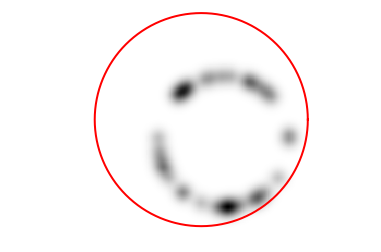

In [27]:
lw = 2
plt.clf
imageplot(transpose(W)) #visualisation des poids
cplot(gamma, 'r', lw) #visualisation de la courbe

In [28]:
dotp = lambda c1,c2: real(c1)*real(c2) + imag(c1)*imag(c2) #produit scalaire?

Evaluation de la courbe.

In [29]:
N = normal(gamma)
g = - EvalW(gamma) * normalC(gamma) + dotp(EvalG(gamma), N) * N
gamma = gamma - dt*g

In [30]:
gamma = resample(gamma) #échantillonage

#### Exercise 2: Perform the curve evolution.

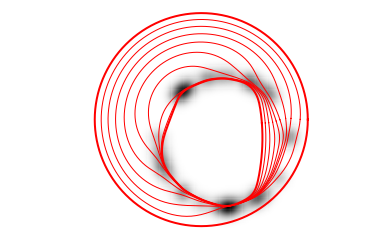

In [31]:
aff = around(linspace(1,niter,10)) #affichage de 10 courbes
k = 0
plt.clf
imageplot(transpose(W))
for i in range(1,niter+1):
    N = normal(gamma)
    g = -EvalW(gamma)*normalC(gamma) + dotp(EvalG(gamma),N)*N
    gamma = resample(gamma - dt*g)  #échantillonage à chaque boucle  
    if i==aff[k]:
        if (i==1 or i==niter):
            cplot(gamma, 'r',lw) #pour courbes extrémités
        else:
            cplot(gamma, 'r') #pour courbes internes

        k = k+1


### Medical Image Segmentation

Il est aussi possible d'utiliser une métrique basée sur une étude de gradient pour détecter des contours. Appliquons cette méthode sur une image médicale par exemple.

/home/cmoriceau/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/cmoriceau/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


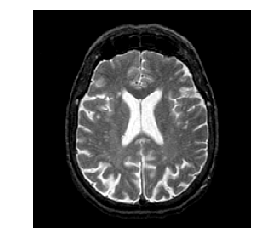

In [32]:
n = 256
name = 'nt_toolbox/nt_toolbox/data/cortex.bmp' # A Revoir pour faire avec chemin relatif
f = load_image('cortex.bmp', n) #download image
imageplot(f) #affichage

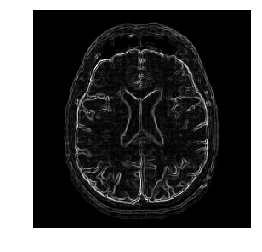

In [33]:
G = grad(f) #calcul du gradient de l'image
d0 = np.sqrt(sum(G**2, 2)) #calcul de la norme 2 du gradient
imageplot(d0) #affichage

Ce détecteur de contour est une fonction décroissante de la magnitude (ie:norme calculée) du gradient. Nous allons tout d'abord flouter l'image par un facteur $a$. Le floutage peut être vu comme la multiplication de la matrice composée de pixels (l'image) et de la matrice de floutage (la matrice gaussienne et divisée par le coefficient $a$).

Par exemple voici une matrice de floutage de type gaussien (dimension 3):
$$ \frac{1}{a}
\begin{bmatrix}
1 & 2 & 1 \\
2 & 4 & 2 \\
1 & 2 & 1
\end{bmatrix}$$

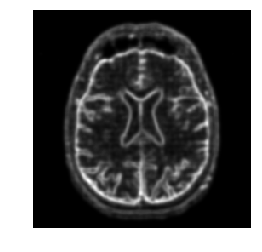

In [34]:
a = 2 #coefficient de floutage
d = gaussian_blur(d0, a) #d0 image initiale --> divisée par a pour le floutage
imageplot(d) #affichage

In [35]:
d = minimum(d, .4)
W = rescale(-d, .8, 1) #redéfinition des poids W

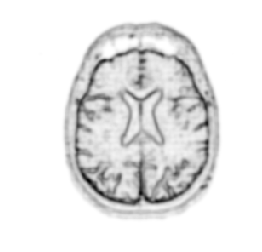

In [36]:
imageplot(W)

Nombre de points

In [37]:
p = 128 #nombre de points sur la courbe

#### Exercise 3: Create an initial circle $\gamma_0$ of $p$ points. When plotting the image, you need to transpose it to have axis coherent with the cplot.

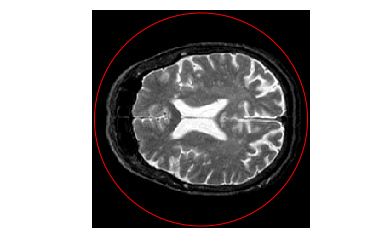

In [38]:
#redéfinition du rayon et de theta (car n a changé), idem pour gamma0
r = .98*n/2;
theta = transpose(linspace(0,2*pi,p+1))
theta = theta[0:-1] #sans derniere valeur
gamma0 = n/2*(1 + 1j) +  r*(np.cos(theta) + 1j*np.sin(theta))

#affectation
gamma = gamma0;
#affichage
plt.clf
imageplot(transpose(f)) #transposée de l'image selon la consigne
cplot(gamma,'r')

Passons à la visualisation de l'évolution de la courbe.

In [39]:
dt = 2 #intervalle de temps

In [40]:
Tmax = 9000 #temps max
niter = round(Tmax/ dt) #nombre max d'itérations

#### Exercise 4: Perform the curve evolution.

Pas hyper précis où sont les courbes bleues donc peut être à revoir...

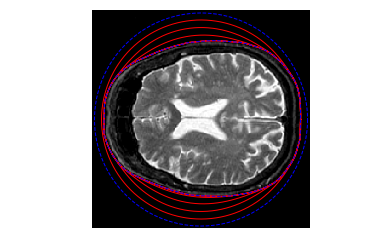

In [41]:
#on était restés à G=grad(f)
G = G[:,:,0] + 1j*G[:,:,1] #IDEM: Laura ici tu vas pouvoir nous aider ;) Je sais plus ce que ça fait l'ajout du dernier indice

aff = around(linspace(1,niter,10))
k = 0
plt.clf
imageplot(transpose(f))
for i in range(1,niter+1):
    N = normal(gamma)
    g = -EvalW(gamma)*normalC(gamma) + dotp(EvalG(gamma), N)*N #réutilisation de EvalW et EvalG (définis avant)
    gamma = resample(gamma - dt*g) #échantillonage à chaque itération 
    if i==aff[k]:
        if (i==1 or i==niter):
            cplot(gamma, 'b--')
        else:
            cplot(gamma, 'r')
            
        k = k+1

### Evolution of a Non-closed Curve

Pour finir nous allons étudier les courbes non fermées. Afin d'afficher leur évolution il faut introduire des conditions aux frontières. Nommons par exemples ces deux contraintes:
$\gamma(0) = x_0$ et $\gamma(1) = x_1$.

/home/cmoriceau/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/cmoriceau/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


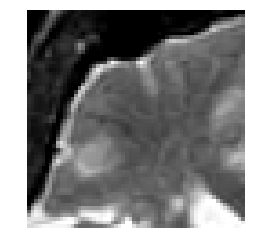

In [42]:
n = 256
f = load_image('cortex.bmp', n) #ALORS ICI POURQUOI AVEC NAME ça FONCTIONNE?? AUCUNE idée...
f = f[45:105, 60:120] #on étudie seulement une partie de l'image
n = f.shape[0] #n prend la valeur du nombre de lignes de la matrice de pixels (égale ici au nombre de colonnes = 60)

#affichage du carré de l'image étudié
imageplot(f)

#### Exercise 5: Compute an edge attracting criterion W(x)>0, that is small in area of strong gradient.

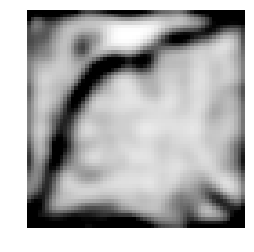

In [43]:
#gradient de f
G = grad(f)
#G0 : norme 2 du gradient
G0 = np.sqrt(sum(G**2, 2))
G = gaussian_blur(G0,a) #afin d'accentuer les valeurs dans l'image (--> filtre gaussien)
G = minimum(G,.2) #0.2 si "strong gradient" ie: dans les régions où G est elevé alors G prendra la valeur de 0.2 (petit) ??
W = rescale(-G,.4,1)
plt.clf
imageplot(W)

Définition des contraintes: $x_0$ et $x_1$.

In [44]:
x0 = 4 + 55j
x1 = 53 + 4j

In [45]:
p = 128 #nombre de points de la courbe
t = transpose(linspace(0, 1, p))
gamma0 = t*x1 + (1-t)*x0 #premiere courbe

In [46]:
gamma = gamma0 #initialisation de l'évolution avec la courbe initiale

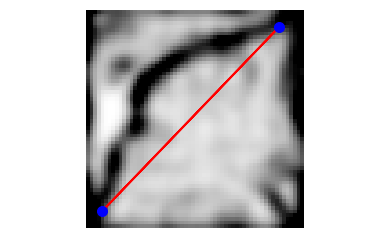

In [47]:
plt.clf
imageplot(transpose(W))
cplot(gamma,'r', 2)
plt.plot(real(gamma[0]), imag(gamma[0]), 'b.', markersize=20)
plt.plot(real(gamma[-1]), imag(gamma[-1]), 'b.', markersize=20);

Définitions de fonctions pour les courbes non périodiques. A REVOIR --> A COMPRENDRE

In [48]:
curvabs = lambda gamma: concatenate( ([0], cumsum( 1e-5 + abs(gamma[:-1:]-gamma[1::]) ) ) )
resample1 = lambda gamma,d: interpc(arange(0,p)/float(p-1),  d/d[-1],gamma)
resample = lambda gamma: resample1( gamma, curvabs(gamma) )

In [49]:
dt = 1/10 #intervalle de temps
Tmax = 2000*4/ 7
niter = round(Tmax/ dt) #nombre maximal d'itérations

#### Exercise 6: Perform the curve evolution. Be careful to impose the boundary conditions at each step.

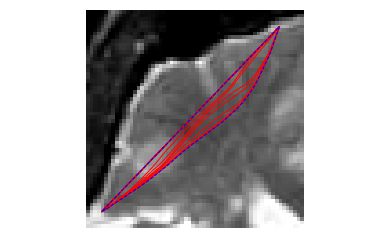

In [50]:
G = grad(f) #gradient de f
G = G[:,:,0] + 1j*G[:,:,1]

aff = around(linspace(1,niter,10))

k = 0
plt.clf
imageplot(f)
for i in range(1,niter+1):
    N = normal(gamma)
    g = -EvalW(gamma)*normalC(gamma) + dotp(EvalG(gamma),N)*N
    gamma = resample(gamma - dt*g) #échantillonage à chaque itération
    gamma[0] = x0
    gamma[-1] = x1 #contraintes aux frontières à ajouter à chaque itération
    if i==aff[k]:
        if (i==1 or i==niter):
            cplot(gamma, 'b--')
        else:
            cplot(gamma, 'r')
        k = k+1